[The 1st IAA-CSIC Severo Ochoa School on Statistics, Data Mining and Machine Learning](https://www.granadacongresos.com/sostat)

[Zeljko Ivezic, University of Washington](http://faculty.washington.edu/ivezic/) 

[This notebook](https://github.com/carmensg/IAA_School2019/tree/master/lectures/Day3-ZeljkoIvezic/notebooks/clustering.ipynb)
### November 6, 2019 

# Lecture 2: Clustering

### o Introduction to clustering
### o K-means algorithm
### o Clustering with GMM
### o Hierarchical clustering 






In [4]:
# first things first...
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy import integrate
from scipy.stats import norm
from scipy.stats import cauchy
# astroML tools 
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
from astroML.plotting.mcmc import convert_to_stdev
setup_text_plots(fontsize=16, usetex=True)
import warnings; warnings.simplefilter('ignore')

![Parker et al. asteroid families](http://www.astro.washington.edu/users/ivezic/sdssmoc/MOC4_population_labels.jpg) 

# Clustering

### Also known as "Unsupervised Classification" 
(what we often call simply "Classification" would be "Supervised Classification"); here “unsupervised” means that there is no prior information about the number and properties of clusters.

### “Clustering” in astronomy refers to a number of different aspects of data analysis.

Given a multivariate point data set, we can ask whether it displays any structure, that is, concentrations of points. Alternatively, when a density estimate is available we can search for “overdensities.”

Another way to interpret clustering is to seek a partitioning or segmentation of data into smaller parts according to some criteria.

Relates to all of the probabilities we have been discussing. 

Will impact classification and many other operations. 

## How do we find clusters or estimate density efficiently?

 

## <u> The _K-means_ algorithm </u>

The first approach for finding clusters that is always taught is $K$-means (simple and works well)

$K$-means partitions points into $K$ disjoint subsets ($C_k$) with each subset containing $N_k$
points 


It minimizes the objective/cost/likelihood function,
## cost = $\sum_{k=1}^K \sum_{i \in C_k} || x_i - \mu_k ||^2$

## $\mu_k = \frac{1}{N_k} \sum_{i \in C_k} x_i$ 
is the mean of the points in set $C_k$


## _Procedure:_

1. define the number of clusters $K$
2. choose the centroid, $\mu_k$, of each of the $K$ clusters
3. assign each point to the cluster that it is closest to
4. update the centroid of each cluster by recomputing $\mu_k$ according to the new assignments.
5. goto (3) until there are no new assignments.

Global optima are not guaranteed but the process never increases the sum-of-squares error.

Typically run multiple times with different starting values for the
centroids of $C_k$.




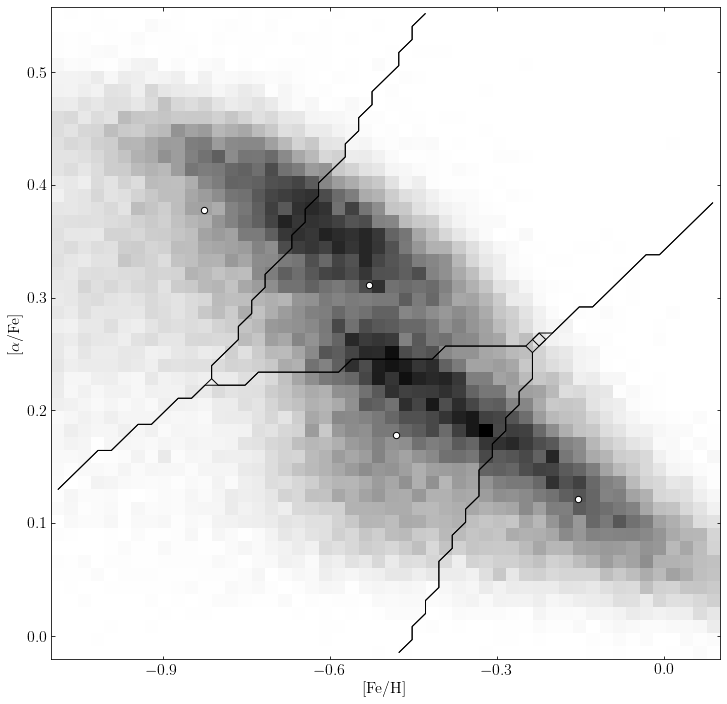

In [9]:
### Modeled after astroML book figure 6.13: 
### https://www.astroml.org/book_figures/chapter6/fig_kmeans_metallicity.html
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn import preprocessing
from astroML.datasets import fetch_sdss_sspp
setup_text_plots(fontsize=16, usetex=True)
#------------------------------------------------------------
# Get data
data = fetch_sdss_sspp(cleaned=True)
X = np.vstack([data['FeH'], data['alphFe']]).T

# truncate dataset for speed
X = X[::5]

#------------------------------------------------------------
# Compute a 2D histogram  of the input
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'], 50)

#------------------------------------------------------------
# Compute the KMeans clustering
n_clusters = 4

scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters)
clf.fit(scaler.fit_transform(X))

#------------------------------------------------------------
# Visualize the results
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()

# plot density
ax = plt.axes()
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

# plot cluster centers
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
FeH_centers = 0.5 * (FeH_bins[1:] + FeH_bins[:-1])
alphFe_centers = 0.5 * (alphFe_bins[1:] + alphFe_bins[:-1])

Xgrid = np.meshgrid(FeH_centers, alphFe_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(FeH_centers, alphFe_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])

ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

plt.show()

# Clustering with Gaussian Mixture Model

@pickle_results: using precomputed results from 'GMM_metallicity.pkl'
best fit converged: True
BIC: n_components =  5


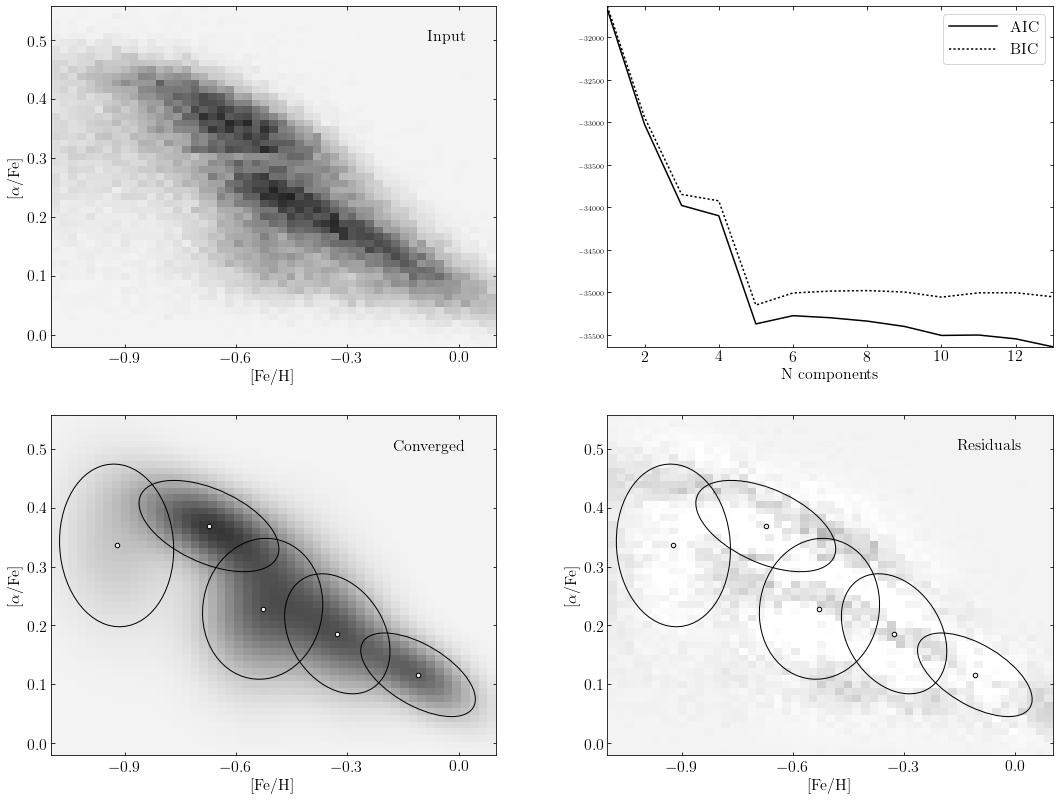

sumData 76127.0
sumModel 75917.25026643055
sumResid 209.74973356945702


In [46]:
### Modeled after astroML book figure 6.6: 
### https://www.astroml.org/book_figures/chapter6/fig_EM_metallicity.html 
from __future__ import print_function

from sklearn.mixture import GaussianMixture
from astroML.datasets import fetch_sdss_sspp
from astroML.utils.decorators import pickle_results
from astroML.plotting.tools import draw_ellipse
setup_text_plots(fontsize=16, usetex=True)

#------------------------------------------------------------
# Get the Segue Stellar Parameters Pipeline data
data = fetch_sdss_sspp(cleaned=True)
Ndata = np.size(data)
X = np.vstack([data['FeH'], data['alphFe']]).T

# truncate dataset for speed
X = X[::5]

#------------------------------------------------------------
# Compute GaussianMixture models & AIC/BIC
N = np.arange(1, 14)

@pickle_results("GMM_metallicity.pkl")
def compute_GaussianMixture(N, covariance_type='full', max_iter=1000):
    models = [None for n in N]
    for i in range(len(N)):
        print(N[i])
        models[i] = GaussianMixture(n_components=N[i], max_iter=max_iter,
                                    covariance_type=covariance_type)
        models[i].fit(X)
    return models

models = compute_GaussianMixture(N)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

i_best = np.argmin(BIC)
gmm_best = models[i_best]
print("best fit converged:", gmm_best.converged_)
print("BIC: n_components =  %i" % N[i_best])

#------------------------------------------------------------
# compute 2D density
FeH_binsN = 51
alphFe_binsN = 51
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'],
                                          (FeH_binsN, alphFe_binsN))

Xgrid = np.array(list(map(np.ravel,
                          np.meshgrid(0.5 * (FeH_bins[:-1]
                                             + FeH_bins[1:]),
                                      0.5 * (alphFe_bins[:-1]
                                             + alphFe_bins[1:]))))).T
log_dens = gmm_best.score_samples(Xgrid).reshape((51, 51))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(16, 16.0))
fig.subplots_adjust(wspace=0.25,
                    bottom=0.25, top=0.9,
                    left=0.1, right=0.97)

vmin = -10 
vmax = 200
# plot density
ax = fig.add_subplot(221)
ax.imshow(H.T, vmin = vmin, vmax = vmax, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(-1.101, 0.101)
ax.text(0.93, 0.93, "Input",
        va='top', ha='right', transform=ax.transAxes)

# plot AIC/BIC
ax = fig.add_subplot(222)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, ':k', label='BIC')
ax.legend(loc=1)
ax.set_xlabel('N components')
plt.setp(ax.get_yticklabels(), fontsize=7)

# plot best configurations for AIC and BIC
ax = fig.add_subplot(223)
scale = np.median(H.T)/np.median(np.exp(log_dens))
image = scale*np.exp(log_dens)
ax.imshow(image, vmin = vmin, vmax = vmax, 
          origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

ax.scatter(gmm_best.means_[:, 0], gmm_best.means_[:, 1], c='w')
for mu, C, w in zip(gmm_best.means_, gmm_best.covariances_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[1.5], ax=ax, fc='none', ec='k')

ax.text(0.93, 0.93, "Converged",
        va='top', ha='right', transform=ax.transAxes)

ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

# plot best configurations for AIC and BIC
ax = fig.add_subplot(224)
image = H.T - scale*np.exp(log_dens)
ax.imshow(image, vmin = vmin, vmax = vmax, 
          origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

ax.scatter(gmm_best.means_[:, 0], gmm_best.means_[:, 1], c='w')
for mu, C, w in zip(gmm_best.means_, gmm_best.covariances_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[1.5], ax=ax, fc='none', ec='k')

ax.text(0.93, 0.93, "Residuals",
        va='top', ha='right', transform=ax.transAxes)

ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

plt.show()

print('sumData', np.sum(H.T))
print('sumModel', np.sum(scale*np.exp(log_dens)))
print('sumResid', np.sum(H.T - scale*np.exp(log_dens)))

@pickle_results: using precomputed results from 'great_wall_GMM.pkl'


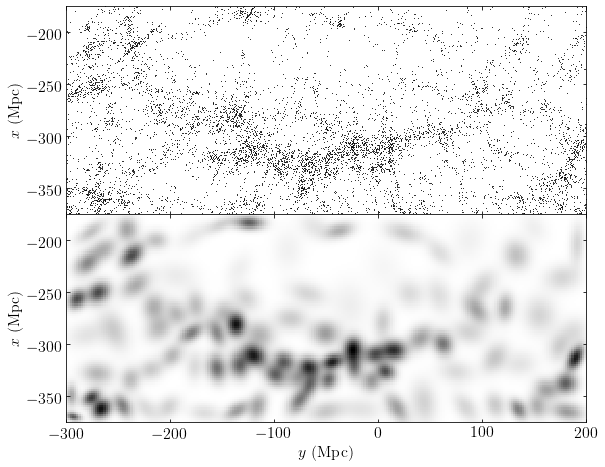

In [5]:
### Modeled after astroML book figure 6.7: 
### https://www.astroml.org/book_figures/chapter6/fig_great_wall_GMM.html
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.mixture import GaussianMixture
from astroML.datasets import fetch_great_wall
from astroML.utils.decorators import pickle_results

#------------------------------------------------------------
# Create a function which will save the results to a pickle file
#  for large number of clusters, computation will take a long time!
@pickle_results('great_wall_GMM.pkl')
def compute_GMM(n_clusters, max_iter=1000, tol=3, covariance_type='full'):
    clf = GaussianMixture(n_clusters, covariance_type=covariance_type,
                          max_iter=max_iter, tol=tol, random_state=0)
    clf.fit(X)
    print("converged:", clf.converged_)
    return clf

#------------------------------------------------------------
# load great wall data
X = fetch_great_wall()

#------------------------------------------------------------
# Compute a grid on which to evaluate the result
Nx = 100
Ny = 250
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

#------------------------------------------------------------
# Compute the results
#
# we'll use 100 clusters.  In practice, one should cross-validate
# with AIC and BIC to settle on the correct number of clusters.
clf = compute_GMM(n_clusters=100)
log_dens = clf.score_samples(Xgrid).reshape(Ny, Nx)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 7.5))
fig.subplots_adjust(hspace=0, left=0.08, right=0.95, bottom=0.13, top=0.9)

ax = fig.add_subplot(211, aspect='equal')
ax.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')

ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)

ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.ylabel(r'$x\ {\rm (Mpc)}$')

ax = fig.add_subplot(212, aspect='equal')
ax.imshow(np.exp(log_dens.T), origin='lower', cmap=plt.cm.binary,
          extent=[ymin, ymax, xmin, xmax])
ax.set_xlabel(r'$y\ {\rm (Mpc)}$')
ax.set_ylabel(r'$x\ {\rm (Mpc)}$')

plt.show()

![slide](figures/slide_clustering.png)

# Hierarchical clustering

Finding all clusters at all scales. 

## _Procedure_

1. partition the data into $N$ clusters (one for each point in the
data set)
2. join two of the clusters (resulting in $N-1$ clusters). 
3. repeat until the $N$th partition contains one cluster. 


If two points are in the same cluster at level $m$, and remain together at all subsequent levels, this is known as _hierarchical clustering_

## _How do we merge components?_

Many ways to merge the points (minimum distance between points in two clusters, maximum distance between points, average distance between points in two clusters)

The example: 
## $d_{\rm min}(C_k,C_{k'})  =  \min_{x \in C_k, x' \in C_{k'}} ||x-x'||$ 

is known as the _minimum spanning tree_. Clusters can then be isolated by sorting the links (or edges) by increasing length and deleting those edges longer than some threshold. (``friends-of-friends'' in clustering)

### The result of hierarchical clustering is called *dendogram*


 scale: 3.54953 Mpc


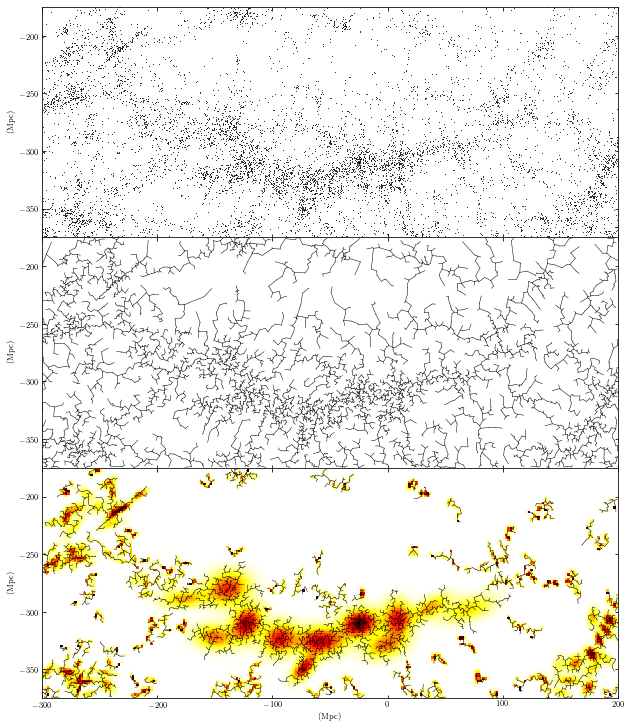

In [7]:
### Modeled after astroML book figure 6.15: 
### https://www.astroml.org/book_figures/chapter6/fig_great_wall_MST.html
from __future__ import print_function, division

import numpy as np
from matplotlib import pyplot as plt

from scipy import sparse
from sklearn.mixture import GaussianMixture

from astroML.clustering import HierarchicalClustering, get_graph_segments
from astroML.datasets import fetch_great_wall

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# get data
X = fetch_great_wall()

xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

#------------------------------------------------------------
# Compute the MST clustering model
n_neighbors = 10
edge_cutoff = 0.9
cluster_cutoff = 10
model = HierarchicalClustering(n_neighbors=10,
                               edge_cutoff=edge_cutoff,
                               min_cluster_size=cluster_cutoff)
model.fit(X)
print(" scale: %2g Mpc" % np.percentile(model.full_tree_.data,
                                        100 * edge_cutoff))

n_components = model.n_components_
labels = model.labels_

#------------------------------------------------------------
# Get the x, y coordinates of the beginning and end of each line segment
T_x, T_y = get_graph_segments(model.X_train_,
                              model.full_tree_)
T_trunc_x, T_trunc_y = get_graph_segments(model.X_train_,
                                          model.cluster_graph_)

#------------------------------------------------------------
# Fit a GaussianMixture to each individual cluster
Nx = 100
Ny = 250
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T
density = np.zeros(Xgrid.shape[0])

for i in range(n_components):
    ind = (labels == i)
    Npts = ind.sum()
    Nclusters = min(12, Npts // 5)
    gmm = GaussianMixture(Nclusters, random_state=0).fit(X[ind])
    dens = np.exp(gmm.score_samples(Xgrid))
    density += dens / dens.max()

density = density.reshape((Ny, Nx))

#----------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 12))
fig.subplots_adjust(hspace=0, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(311, aspect='equal')
ax.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('(Mpc)')

ax = fig.add_subplot(312, aspect='equal')
ax.plot(T_y, T_x, c='k', lw=0.5)
ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('(Mpc)')

ax = fig.add_subplot(313, aspect='equal')
ax.plot(T_trunc_y, T_trunc_x, c='k', lw=0.5)
ax.imshow(density.T, origin='lower', cmap=plt.cm.hot_r,
          extent=[ymin, ymax, xmin, xmax])

ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.set_xlabel('(Mpc)')
ax.set_ylabel('(Mpc)')

plt.show()

## Let's compare GMM and hierarchical clustering with SDSS  data for asteroids
 

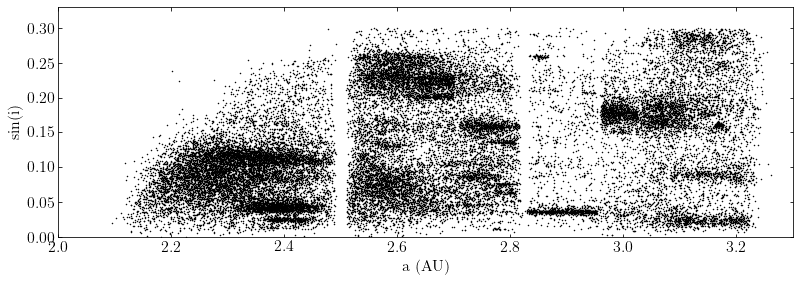

In [49]:
# Fetch data and extract the desired quantities
from astroML.datasets import fetch_moving_objects
dataAll = fetch_moving_objects(Parker2008_cuts=True)
data = dataAll[1:]
a = data['aprime']
sini = data['sin_iprime']
acolor = data['mag_a']
izcolor = data['mag_i'] - data['mag_z']
# matrix X is our "main data carrier"
X = np.vstack([a, sini]).T

#------------------------------------------------------------
# Plot 
xmin, xmax = (2.0, 3.3)
ymin, ymax = (0.0, 0.33)
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(311)
ax.scatter(X[:, 0], X[:, 1], s=1, lw=0.5, c='k')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('a (AU)')
ax.set_ylabel('sin(i)')

plt.show()

In [51]:
#------------------------------------------------------------
# Compute GMM models & AIC/BIC
N = np.arange(1, 60)
def compute_GaussianMixture(N, dataMatrix, covariance_type='full', max_iter=100):
    models = [None for n in N]
    for i in range(len(N)):
        print(N[i])
        models[i] = GaussianMixture(n_components=N[i], max_iter=max_iter,
                                    covariance_type=covariance_type)
        models[i].fit(dataMatrix)
    return models

models = compute_GaussianMixture(N, X)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]
i_best = np.argmin(BIC)
gmm_best = models[i_best]

print("best fit converged:", gmm_best.converged_)
print("BIC: n_components =  %i" % N[i_best])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
best fit converged: True
BIC: n_components =  35


0 14 0.05526339752935943
1 0 0.04906341497854917
2 29 0.04466729901561734
3 2 0.04374559728638124
4 5 0.0430776003147473
5 24 0.042767788323060954
6 25 0.04276625263018221
7 11 0.03999156017042689
8 4 0.03902417699065316
9 3 0.03706240764061046
10 16 0.036553802369741886
11 8 0.035418409279811186
12 32 0.03528737262888898
13 7 0.03398437003767519
14 18 0.03261249558079289
15 27 0.028048602639237585
16 26 0.02717867455137424
17 33 0.025572319791334116
18 10 0.025061811799343227
19 6 0.024510705354241994
20 9 0.022844313063407867
21 23 0.021985829380858184
22 28 0.020993472756145846
23 22 0.02048250516381707
24 21 0.01977806311183467
25 34 0.018927651735499342
26 30 0.0188757685839323
27 17 0.018655459363064505
28 12 0.017773340554266093
29 13 0.016169493893810883
30 19 0.016092085945992207
31 1 0.01557640924608594
32 20 0.013775183916083818
33 31 0.013011408435525363
34 15 0.003400955937640929


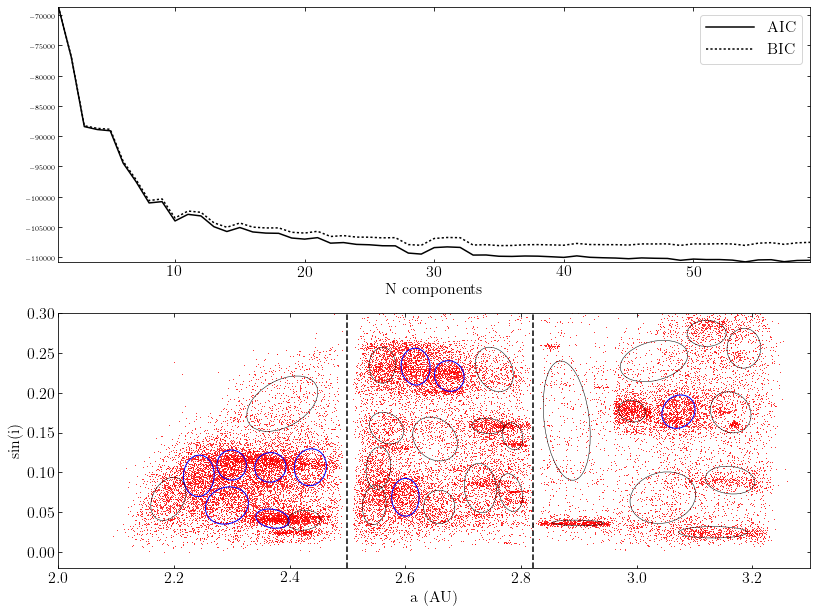

In [52]:
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(wspace=0.45, bottom=0.25, top=0.9, left=0.1, right=0.97)

# plot AIC/BIC
ax = fig.add_subplot(211)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, ':k', label='BIC')
ax.legend(loc=1)
ax.set_xlabel('N components')
plt.setp(ax.get_yticklabels(), fontsize=7)

# plot best configurations for AIC and BIC
ax = fig.add_subplot(212)

ax.scatter(a, sini, c='red', s=1, lw=0)

ind = np.argsort(gmm_best.weights_)[::-1]
for cnt, i in enumerate(ind[:N[i_best]]):
    mu = gmm_best.means_[i]
    C = gmm_best.covariances_[i]
    w = gmm_best.weights_[i]
    print(cnt, i, w)
    if (cnt<10):
        draw_ellipse(mu, C, scales=[1.0], ax=ax, fc='none', lw=1.0, ec='blue')
    else:
        draw_ellipse(mu, C, scales=[1.0], ax=ax, fc='none', lw=0.5, ec='k')
 
ax.plot([2.5, 2.5], [-0.02, 0.3], '--k')
ax.plot([2.82, 2.82], [-0.02, 0.3], '--k')

ax.set_xlim(2.0, 3.3)
ax.set_ylim(-0.02, 0.3)

ax.set_xlabel('a (AU)')
ax.set_ylabel('sin(i)')

plt.show()

In [53]:
#------------------------------------------------------------
# Compute the Minimum Spanning Tree clustering model
n_neighbors = 10
edge_cutoff = 0.9
cluster_cutoff = 10
model = HierarchicalClustering(n_neighbors=10, edge_cutoff=edge_cutoff,
                               min_cluster_size=cluster_cutoff)
model.fit(X)
print(" scale: %2g" % np.percentile(model.full_tree_.data,
                                        100 * edge_cutoff))
n_components = model.n_components_
labels = model.labels_
#------------------------------------------------------------
# Get the x, y coordinates of the beginning and end of each line segment
T_x, T_y = get_graph_segments(model.X_train_,
                              model.full_tree_)
T_trunc_x, T_trunc_y = get_graph_segments(model.X_train_,
                                          model.cluster_graph_)

 scale: 0.00319149


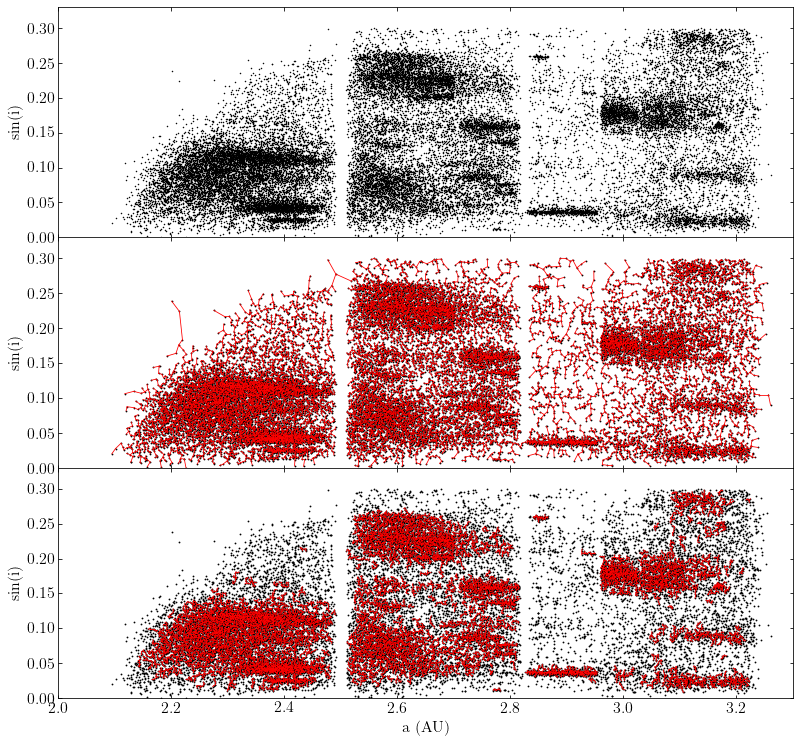

In [54]:
#------------------------------------------------------------
# Plot the results
xmin, xmax = (2.0, 3.3)
ymin, ymax = (0.0, 0.33)
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(311)
ax.scatter(X[:, 0], X[:, 1], s=1, lw=0.5, c='k')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('sin(i)')

ax = fig.add_subplot(312)
ax.scatter(X[:, 0], X[:, 1], s=1, lw=0.8, c='k')
ax.plot(T_x, T_y, c='red', lw=0.8)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('sin(i)')

ax = fig.add_subplot(313)
ax.scatter(X[:, 0], X[:, 1], s=1, lw=0.8, c='k')
ax.plot(T_trunc_x, T_trunc_y, c='red', lw=0.8)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('a (AU)')
ax.set_ylabel('sin(i)')

plt.show()